# Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
from pprint import pprint

# Gensim
from lda_modify_inference import modify_lda_inference
modify_lda_inference()
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
#from gensim.parsing.preprocessing import STOPWORDS

# nltk
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'use'])

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 

# Enable logging for gensim
#import logging
#logging.basicConfig(filename='gensim.log',
#                    format="%(asctime)s:%(levelname)s:%(message)s",
#                    level=logging.INFO)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [34]:
scores = pd.read_csv('data/cleaned_scores_final.csv')
handles = pd.read_csv('data/realHandles_final.csv')
data = pd.read_csv('data/final_data.csv')

In [35]:
scores.head()

,mtkid,Harm,Fairness,Loyalty,Authority,Purity,ICS_score,Political Involvement,Political Leaning
0,A3L0DCUXI7X3A9,18,17,12,20,19,6,3,conservative
1,A3I40B0FATY8VH,21,24,24,15,3,8,7,conservative
2,A2MCRVU8I9VNHG,17,22,11,16,22,8,4,conservative
3,A1PJUYJ7W2LKKQ,24,24,10,17,9,-4,5,slightly
4,A1KZ21TSAYUHO4,25,29,16,19,29,4,2,slightly


In [36]:
handles.head()

,handle,mtkid,listed_status,real_status,follower_range,actual_followers,isReal,tweet_count
0,kaplan175,A3L0DCUXI7X3A9,Public,Public,0|100,1,True,2
1,EvilRussianBot,A3I40B0FATY8VH,Public,Public,0|100,37,True,1867
2,CtheFrood,A2MCRVU8I9VNHG,Public,Public,0|100,8,True,128
3,thom1nDun,A1PJUYJ7W2LKKQ,Public,Public,0|100,89,True,1872
4,bigearnhardtfan,A1KZ21TSAYUHO4,Public,Public,0|100,19,True,237


In [37]:
data.head()

,user_id,created_at,text,is_retweet,mtkid
0,138613910,2013-12-21 18:45:29,tried adding to my Tivo and have been inform...,False,A3L0DCUXI7X3A9
1,138613910,2011-12-28 23:32:53,Why are new DC comics no longer available in ...,False,A3L0DCUXI7X3A9
2,821070135951847432,2019-05-16 17:55:12,,False,A3I40B0FATY8VH
3,821070135951847432,2019-05-16 02:01:50,Keep screeching Maybe someone will take y...,False,A3I40B0FATY8VH
4,821070135951847432,2019-05-15 21:48:17,And the crowd goes mild,False,A3I40B0FATY8VH


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464642 entries, 0 to 464641
Data columns (total 5 columns):
user_id       464642 non-null int64
created_at    464642 non-null object
text          458917 non-null object
is_retweet    464642 non-null bool
mtkid         464642 non-null object
dtypes: bool(1), int64(1), object(3)
memory usage: 14.6+ MB


In [39]:
data['user_id'].nunique()

406

An initial look at the final data shows that there are $406$ unique users and about $450$k tweets.  There appears to be about 6k tweets that don't have any text. 

# Preprocessing

First, let's drop duplicates and then drop the rows that don't have any text in them.

In [40]:
data.drop_duplicates(inplace=True)
data['text'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
data.dropna(axis=0, subset=['text'], inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440651 entries, 0 to 464641
Data columns (total 5 columns):
user_id       440651 non-null int64
created_at    440651 non-null object
text          440651 non-null object
is_retweet    440651 non-null bool
mtkid         440651 non-null object
dtypes: bool(1), int64(1), object(3)
memory usage: 17.2+ MB


Now, let's lowercase the text.

In [28]:
data.head()

,user_id,created_at,text,is_retweet,mtkid
0,138613910,2013-12-21 18:45:29,tried adding to my Tivo and have been inform...,False,A3L0DCUXI7X3A9
1,138613910,2011-12-28 23:32:53,Why are new DC comics no longer available in ...,False,A3L0DCUXI7X3A9
3,821070135951847432,2019-05-16 02:01:50,Keep screeching Maybe someone will take y...,False,A3I40B0FATY8VH
4,821070135951847432,2019-05-15 21:48:17,And the crowd goes mild,False,A3I40B0FATY8VH
5,821070135951847432,2019-05-15 21:47:50,gtEverything is Hitler Guys,False,A3I40B0FATY8VH


In [41]:
data = data[['user_id', 'mtkid', 'text']].groupby(['mtkid', 'user_id']).agg(lambda x: ' '.join(x)).reset_index()

In [42]:
data.head()

,mtkid,user_id,text
0,8298177,1182255055,What if we found out that theres no such thi...
1,A0467121226LDESR9HWNF,48986589,What you should be saying is the American peo...
2,A102VHF4S7WXQF,1543109004,Literally me Jj ale s dvomi y Im going g...
3,A110ICG2VQUGXS,336224329,If I have an ear infection caused by bacteria...
4,A11A83GK7BV037,2816195965,I wish everyone followed this logic in EVERY ...


In [43]:
data['text'] = data['text'].map(lambda x: x.lower())

text_data = data[['mtkid', 'text']]

In [44]:
def sent_to_words(sentences):
    for sentence in tqdm_notebook(sentences, total=len(sentences)):
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data['text']))
text_data['text_list'] = data_words

A Jupyter Widget

In [45]:
text_data.head()

,mtkid,text,text_list
0,8298177,what if we found out that theres no such thi...,"[what, if, we, found, out, that, theres, no, s..."
1,A0467121226LDESR9HWNF,what you should be saying is the american peo...,"[what, you, should, be, saying, is, the, ameri..."
2,A102VHF4S7WXQF,literally me jj ale s dvomi y im going g...,"[literally, me, jj, ale, dvomi, im, going, giv..."
3,A110ICG2VQUGXS,if i have an ear infection caused by bacteria...,"[if, have, an, ear, infection, caused, by, bac..."
4,A11A83GK7BV037,i wish everyone followed this logic in every ...,"[wish, everyone, followed, this, logic, in, ev..."


In [46]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/Users/Raymond/anaconda/lib/python3.5/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [47]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in tqdm_notebook(texts, total=len(texts), desc='stopword removal')]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in tqdm_notebook(texts, total=len(texts), desc='bigrams')]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in tqdm_notebook(texts, total=len(texts), desc='trigram')]

# ADD TQDM HERE BC IT TAKES FOREVER
def lemmatization(texts, allowed_postags={'NOUN', 'ADJ', 'VERB', 'ADV'}):
    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    
    nlp = spacy.load('en', disable=['parser', 'ner'])
    texts_out = []
    for sent in tqdm_notebook(texts, total=len(texts), desc='lemmatization'):
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [48]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

A Jupyter Widget

A Jupyter Widget

In [49]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in tqdm_notebook(texts, total=len(texts), desc='corpus')]

In [50]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=20, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

In [51]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"thank" + 0.011*"get" + 0.010*"go" + 0.009*"day" + 0.008*"great" + '
  '0.008*"lol" + 0.007*"new" + 0.007*"watch" + 0.006*"not" + 0.006*"today"'),
 (1,
  '0.016*"not" + 0.011*"trump" + 0.009*"do" + 0.008*"say" + 0.008*"people" + '
  '0.007*"s" + 0.007*"be" + 0.006*"would" + 0.005*"get" + 0.005*"make"'),
 (2,
  '0.037*"be" + 0.029*"not" + 0.020*"get" + 0.018*"do" + 0.015*"go" + '
  '0.011*"s" + 0.011*"fuck" + 0.009*"love" + 0.009*"know" + 0.008*"people"'),
 (3,
  '0.030*"be" + 0.016*"not" + 0.013*"get" + 0.013*"go" + 0.010*"do" + '
  '0.010*"feel" + 0.009*"have" + 0.008*"love" + 0.008*"really" + 0.008*"day"'),
 (4,
  '0.017*"miss" + 0.014*"find" + 0.011*"man" + 0.009*"korean" + '
  '0.008*"south_korea" + 0.008*"korea" + 0.007*"lafayette" + 0.007*"woman" + '
  '0.007*"seoul" + 0.006*"police"'),
 (5,
  '0.019*"not" + 0.015*"get" + 0.013*"be" + 0.011*"good" + 0.011*"do" + '
  '0.010*"go" + 0.008*"game" + 0.007*"would" + 0.007*"make" + 0.006*"time"'),
 (6,
  '0.093*"nothing" +

In [52]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.2950957856263

Coherence Score:  0.38314764875035234


In [53]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis.

/Users/Raymond/anaconda/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      25.114351        1       1 -0.264845 -0.069720
5      24.937210        1       2 -0.304199  0.005381
2      13.168520        1       3 -0.317508  0.006863
0      10.053576        1       4 -0.277098  0.056603
3       7.922777        1       5 -0.336553 -0.013081
11      7.375307        1       6 -0.167526  0.146835
15      4.297181        1       7 -0.192906  0.061912
4       1.959372        1       8 -0.021578 -0.009565
9       0.921545        1       9  0.109931  0.088051
18      0.765975        1      10  0.132407  0.053706
6       0.736446        1      11  0.159335  0.008323
13      0.732984        1      12  0.067610  0.037568
7       0.517273        1      13 -0.058923 -0.327374
8       0.468825        1      14  0.149517 -0.059441
14      0.327799        1      15  0.187011  0.032871
16      0.289842        1      16  0.222246 -0.008442
19      0.282847        1      17  0.216006 -0.004768
10      0.085387        1      18  0.233746 -0.002585
17      0.024233        1      19  0.232222 -0.001766
12      0.018546        1      20  0.231105 -0.001371, topic_info=       Category          Freq                  Term         Total  loglift  \
term                                                                         
97541   Default  17153.000000                   win  17153.000000  30.0000   
105031  Default  39625.000000                    be  39625.000000  29.0000   
80981   Default   4531.000000               nothing   4531.000000  28.0000   
78454   Default   8857.000000                 thank   8857.000000  27.0000   
128097  Default   8892.000000                chance   8892.000000  26.0000   
114027  Default   7605.000000                 enter   7605.000000  25.0000   
127959  Default  10684.000000                  love  10684.000000  24.0000   
47791   Default   7988.000000                 great   7988.000000  23.0000   
4786    Default  14055.000000                   day  14055.000000  22.0000   
9137    Default  18581.000000                  good  18581.000000  21.0000   
127566  Default   4203.000000                  hear   4203.000000  20.0000   
67983   Default   5075.000000                   may   5075.000000  19.0000   
131636  Default   8981.000000                 today   8981.000000  18.0000   
4507    Default   5451.000000                 tweet   5451.000000  17.0000   
76265   Default   7677.000000                follow   7677.000000  16.0000   
90182   Default   8563.000000                  game   8563.000000  15.0000   
123871  Default   2880.000000                report   2880.000000  14.0000   
33404   Default  10995.000000                   new  10995.000000  13.0000   
7231    Default   4424.000000                 check   4424.000000  12.0000   
47876   Default   8711.000000                 trump   8711.000000  11.0000   
14011   Default  44449.000000                   not  44449.000000  10.0000   
88845   Default   6132.000000                  find   6132.000000   9.0000   
80317   Default   2811.000000                 share   2811.000000   8.0000   
61788   Default   2053.000000  industrial_automaton   2053.000000   7.0000   
116616  Default  14052.000000                people  14052.000000   6.0000   
56058   Default   6755.000000                   man   6755.000000   5.0000   
1240    Default  33227.000000                   get  33227.000000   4.0000   
113897  Default  24511.000000                    go  24511.000000   3.0000   
4229    Default   7982.000000                 watch   7982.000000   2.0000   
74543   Default   3664.000000              giveaway   3664.000000   1.0000   
...         ...           ...                   ...           ...      ...   
37942   Topic20      0.084435            discountps      0.957314   6.1645   
61625   Topic20      0.084435        morecensorship      0.957314   6.1645   
61578   Topic20      0.084435          

In [54]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [55]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(2,
  [('aquarius', 0.04276289800110611),
   ('day', 0.0374101287824919),
   ('great', 0.032057359563877695),
   ('today', 0.019633404440230703),
   ('bitcoin', 0.013944852650707119),
   ('price', 0.013510310500118512),
   ('nasa', 0.013490558584182665),
   ('book', 0.012186932132416844),
   ('everyone_current', 0.011021569092201944),
   ('blog_post', 0.008552579600221221)]),
 (3,
  [('miss', 0.039345138931737314),
   ('find', 0.029082083873223506),
   ('man', 0.015446000699286316),
   ('woman', 0.013903457353818309),
   ('person', 0.012031838094650459),
   ('korean', 0.009851710166389008),
   ('korea', 0.009378663540445486),
   ('search', 0.009234692828201805),
   ('south_korea', 0.008617675490014604),
   ('family', 0.00835030131013348)]),
 (17,
  [('fuck', 0.03287428273343766),
   ('shit', 0.022086593635889412),
   ('video', 0.012217005738132499),
   ('photo', 0.010860719874804381),
   ('bitch', 0.010787689097548252),
   ('man', 0.008544600938967136),
   ('ass', 0.008367240479916537

In [62]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm_notebook(range(start, limit, step), total=(limit - start) // step, desc='compute_coherence'):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherencemodel.get_coherence()
        coherence_values.append(coherence_score)
        print(coherence_score)

    return model_list, coherence_values

In [65]:
START = 200
LIMIT = 401
STEP = 10

In [63]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=START, 
                                                        limit=LIMIT, step=STEP)

A Jupyter Widget

<bound method CoherenceModel.get_coherence of <gensim.models.coherencemodel.CoherenceModel object at 0x1a9de7e198>>
<bound method CoherenceModel.get_coherence of <gensim.models.coherencemodel.CoherenceModel object at 0x1a3b62c0b8>>
<bound method CoherenceModel.get_coherence of <gensim.models.coherencemodel.CoherenceModel object at 0x1a2de41cc0>>
<bound method CoherenceModel.get_coherence of <gensim.models.coherencemodel.CoherenceModel object at 0x1a39681630>>
<bound method CoherenceModel.get_coherence of <gensim.models.coherencemodel.CoherenceModel object at 0x1a2f83a080>>
<bound method CoherenceModel.get_coherence of <gensim.models.coherencemodel.CoherenceModel object at 0x1a8a7a7978>>
<bound method CoherenceModel.get_coherence of <gensim.models.coherencemodel.CoherenceModel object at 0x1a2f83a080>>
<bound method CoherenceModel.get_coherence of <gensim.models.coherencemodel.CoherenceModel object at 0x1aa94eca20>>
<bound method CoherenceModel.get_coherence of <gensim.models.coherencemo

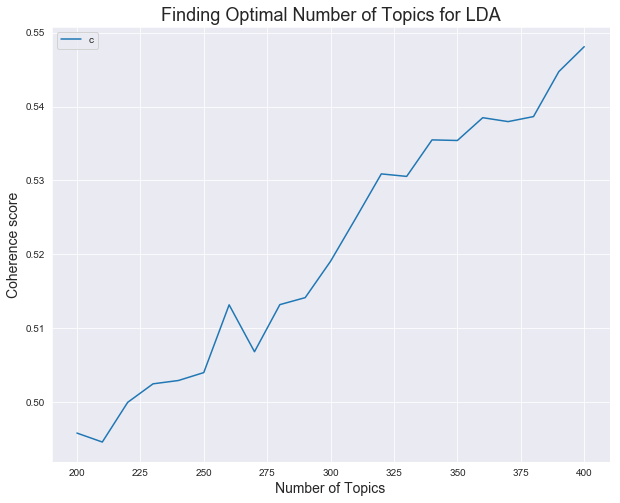

In [69]:
# Show graph
sns.set_style('darkgrid')
plt.figure(figsize=(10, 8))

x = range(START, LIMIT, STEP)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics", fontsize=14)
plt.ylabel("Coherence score", fontsize=14)
plt.legend(("coherence_values"), loc='best')
plt.title('Finding Optimal Number of Topics for LDA', fontsize=18)
plt.savefig('LDA_Coherence_Scores.png')

In [67]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 200  has Coherence Value of 0.4958
Num Topics = 210  has Coherence Value of 0.4946
Num Topics = 220  has Coherence Value of 0.5
Num Topics = 230  has Coherence Value of 0.5025
Num Topics = 240  has Coherence Value of 0.5029
Num Topics = 250  has Coherence Value of 0.504
Num Topics = 260  has Coherence Value of 0.5132
Num Topics = 270  has Coherence Value of 0.5068
Num Topics = 280  has Coherence Value of 0.5132
Num Topics = 290  has Coherence Value of 0.5141
Num Topics = 300  has Coherence Value of 0.5191
Num Topics = 310  has Coherence Value of 0.5249
Num Topics = 320  has Coherence Value of 0.5309
Num Topics = 330  has Coherence Value of 0.5306
Num Topics = 340  has Coherence Value of 0.5355
Num Topics = 350  has Coherence Value of 0.5354
Num Topics = 360  has Coherence Value of 0.5385
Num Topics = 370  has Coherence Value of 0.538
Num Topics = 380  has Coherence Value of 0.5386
Num Topics = 390  has Coherence Value of 0.5447
Num Topics = 400  has Coherence Value of 0.54

In [96]:
# Select the model and print the topics
optimal_model = model_list[-1]
model_topics = optimal_model.show_topics(num_topics=-1, formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(227,
  '0.021*"martha" + 0.014*"tear" + 0.007*"countedor" + 0.007*"daug" + '
  '0.007*"touchdown" + 0.007*"gott" + 0.007*"americamedia" + 0.007*"goby" + '
  '0.007*"blessingand" + 0.007*"basementdwe"'),
 (75,
  '0.015*"eeeettt" + 0.015*"trainspott" + 0.015*"webs" + 0.015*"itt" + '
  '0.015*"mommys" + 0.015*"zzzzzzzzzzzz" + 0.015*"china" + 0.015*"onscrub" + '
  '0.015*"shurmur" + 0.015*"aintwhat"'),
 (350,
  '0.047*"haha" + 0.028*"tahoe" + 0.023*"beach" + 0.021*"oakland" + '
  '0.019*"baseball" + 0.014*"state" + 0.013*"raider" + 0.013*"lake_tahoe" + '
  '0.013*"nba" + 0.012*"solid"'),
 (28,
  '0.048*"matt" + 0.036*"bus" + 0.029*"prac" + 0.023*"grad_school" + '
  '0.016*"niece" + 0.013*"counselor" + 0.012*"captel" + 0.010*"zach" + '
  '0.009*"counseling" + 0.009*"belat"'),
 (222,
  '0.015*"petroleum" + 0.010*"devouring" + 0.010*"reciepe" + '
  '0.010*"vivekananda" + 0.010*"midwinter" + 0.005*"spre" + 0.005*"pocketbak" '
  '+ 0.005*"lilithson" + 0.005*"sabina" + 0.005*"displace"'),
 (25

In [105]:
topics = pd.Series([topic[0] for topic in model_topics], name='Topic_Number')
lda_importance = pd.Series([topic[1] for topic in model_topics], name='LDA_Equation')

optimal_model_df = pd.concat([topics, lda_importance], axis=1)
optimal_model_df.head()

,Topic_Number,LDA_Equation
0,0,"[(libertarian, 0.04827586206896552), (juniper,..."
1,1,"[(islander, 0.016216216216216217), (spawn, 0.0..."
2,2,"[(booze, 0.014084507042253521), (esoteric, 0.0..."
3,3,"[(prizes_daysday, 0.031496062992125984), (capi..."
4,4,"[(snowballish, 0.010638297872340425), (barnes_..."


In [106]:
optimal_model_df.to_csv('data/lda_topics_and_weights_400_topics.csv')

In [108]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, df=data, perc_contri_threshold=0.01):
    # Init output
    sent_topics_df = pd.DataFrame()

    topic_list = []
    # Get main topic in each document
    for i, row in tqdm_notebook(enumerate(ldamodel[corpus]), total=len(ldamodel[corpus]), desc='main topic in each doc'):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        topic_list_per_doc = []
        
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            if prop_topic >= perc_contri_threshold:
                topic_list_per_doc.append(topic_num)
        topic_list.append(topic_list_per_doc)
                
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = df['text']
    mtkid = df['mtkid']
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df = pd.concat([sent_topics_df, mtkid], axis=1)
    
    sent_topics_df['topic_list'] = pd.Series(topic_list)
    
    return (sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, df=data, perc_contri_threshold=0.01)

A Jupyter Widget

In [109]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Dominant_Topic_Perc_Contrib', 'Dominant_Topic_Keywords', 'Text', 'mtkid', 'Topic_List']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Dominant_Topic_Perc_Contrib,Dominant_Topic_Keywords,Text,mtkid,Topic_List
0,0,229.0,0.1810,"people, make, time, man, call, good, talk, lif...",what if we found out that theres no such thi...,8298177,"[229, 233, 241, 92, 5, 130, 108, 279, 188, 228..."
1,1,367.0,0.2918,"bragging_right, cars_battle, dream_mustang, bu...",what you should be saying is the american peo...,A0467121226LDESR9HWNF,"[367, 108, 47, 188, 159, 229, 82, 92, 233, 213..."
2,2,47.0,0.1854,"good, win, great, watch, year, tonight, play, ...",literally me jj ale s dvomi y im going g...,A102VHF4S7WXQF,"[47, 108, 242, 144, 229, 81, 5, 213, 74, 82]"
3,3,73.0,0.0700,"pottery, fucktrump, bacteria, simon, hairbecau...",if i have an ear infection caused by bacteria...,A110ICG2VQUGXS,"[73, 47, 108, 241, 32, 341]"
4,4,373.0,0.1074,"vote, trump, american, people, election, state...",i wish everyone followed this logic in every ...,A11A83GK7BV037,"[373, 108, 229, 5, 89, 213, 121, 228, 294, 0, ..."
5,5,81.0,0.0181,"game, play, good, people, buy, pc, hour, ps, f...",i have always enjoyed you and your music just...,A12I4JOVZ1HZW8,"[81, 256, 213, 294]"
6,6,5.0,0.1603,"year, people, give, make, point, show, time, g...",i read that tweet several months back before ...,A12JZYXJMB6BG4,"[5, 139, 241, 108, 373, 213, 261, 47, 229, 151]"
7,7,92.0,0.3168,"find, cat, food, dog, hot, eat, baby, set, cut...",january 1st threw december 31st 2019 free ship...,A12NNJKHIZP1TY,"[92, 172, 240, 187, 108, 128, 86, 213]"
8,8,47.0,0.1730,"good, win, great, watch, year, tonight, play, ...",meeting with some south bend locals today ...,A12NO2MNOIREXA,"[47, 167, 108, 279, 82, 373, 381, 211, 121, 5,..."
9,9,395.0,0.4270,"aquarius, today, feel, friend, feeling, fun, b...",your independent spirit is fully unleashed whe...,A12WRJ2ZMDW3SU,"[395, 139, 229, 213, 20, 108, 5, 256]"


In [110]:
df_dominant_topic.to_csv('data/lda_results.csv', index=False)

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics